In [1]:
"""
	Function: Run training and test processes for source source localization on simulated dataset

    Reference: Bing Yang, Hong Liu, and Xiaofei Li, “SRP-DNN: Learning Direct-Path Phase Difference for Multiple Moving Sound Source Localization,” 
	IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 2022, pp. 721–725.
	Author:    Bing Yang
    Copyright Bing Yang
"""

'\n\tFunction: Run training and test processes for source source localization on simulated dataset\n\n    Reference: Bing Yang, Hong Liu, and Xiaofei Li, “SRP-DNN: Learning Direct-Path Phase Difference for Multiple Moving Sound Source Localization,” \n\tIEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 2022, pp. 721–725.\n\tAuthor:    Bing Yang\n    Copyright Bing Yang\n'

In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True  # The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cudnn.allow_tf32 = True  # The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.

import numpy as np
import time
import scipy.io

from tensorboardX import SummaryWriter
import Dataset as at_dataset
import LearnerSRPDNN as at_learner
import ModelSRPDNN as at_model
import Module as at_module
from Dataset import Parameter
from utils import set_seed, set_random_seed, set_learning_rate

In [3]:
import os
from OptSRPDNN import opt

paras = {
    "gpu_id":'0', 
    'array_name':'cross_array', 
    "localize_mode":['IDL', 'unkNum', '1'], 
    "bs":[1, 1, 1], 
    "checkpoint_start":False, 
    "epochs":10, 
    "eval_mode":['locata', 'pred', 'eval'], 
    "gen_on_the_fly":True, 
    "lr":0.001, 
    "no_cuda":False, 
    "seed":1, 
    "source_state":'static', 
    "sources":[1], 
    "test":True, 
    "time":'02241431', 
    "train":False, 
    "use_amp":False, 
    "workers":0
    }
opts = opt(paras)
args = opts.parse()
dirs = opts.dir()
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id

In [4]:
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id) if use_cuda else {}

set_seed(args.seed)

# %% Dataset
speed = 343.0
fs = 16000
T = 5 # Trajectory length (s) # 20s->5s  
if args.source_state == 'static':
	traj_points = 1 # number of RIRs per trajectory
elif args.source_state == 'mobile':
	traj_points = int(10*T) # number of RIRs per trajectory
else:
	print('Source state model unrecognized~')

# Array
array = args.array_name

if array == '2ch':
	array_setup = at_dataset.dualch_array_setup
	array_locata_name = 'dicit'
elif array == '13ch':
	array_setup = at_dataset.dicit_array_setup_13ch
	array_locata_name = 'benchmark2'  # Name of the array in the LOCATA dataset
elif array == '7ch':
	array_setup = at_dataset.dicit_array_setup_7ch
	array_locata_name = 'benchmark2'  # Name of the array in the LOCATA dataset
elif array == '5ch':
	array_setup = at_dataset.dicit_array_setup_5ch
	array_locata_name = 'benchmark2'  # Name of the array in the LOCATA dataset
elif array == '3ch':
	array_setup = at_dataset.dicit_array_setup_3ch
	array_locata_name = 'benchmark2'  # Name of the

elif array == '12ch':
	array_setup = at_dataset.benchmark2_array_setup
	array_locata_name = 'benchmark2'  # Name of the array in the LOCATA dataset

elif array == 'cross_array':
	array_setup = at_dataset.cross_array
	array_locata_name = 'cross'  # Name of the array in the LOCATA dataset
elif array == 'circular_array':
	array_setup = at_dataset.circular_array
	array_locata_name = 'circular'  # Name of the array in the LOCATA dataset
elif array == 'triangle_array':
	array_setup = at_dataset.triangle_array
	array_locata_name = 'triangle'  # Name of the array in the LOCATA dataset

# Source signal
sourceDataset_test = at_dataset.LibriSpeechDataset(
	path = dirs['sousig_test'], 
	T = T, 
	fs = fs, 
	num_source = max(args.sources),  
	return_vad=True, 
	clean_silence=True)

# Noise signal
noiseDataset_test = at_dataset.NoiseDataset(
	T = T, 
	fs = fs, 
	nmic = array_setup.mic_pos.shape[0], 
	noise_type = Parameter(['spatial_white'], discrete=True), 
	noise_path = None, 
	c = speed)

# Segmenting, STFT parameters
# When win_shift_ratio = 0.5, then the number of time frames corresponding to one segment can be set to an integer
win_len = 512
nfft = 512
win_shift_ratio = 0.5
fre_used_ratio = 1
if args.source_state == 'static':
	seg_len = T*fs
	seg_shift = 1
elif args.source_state == 'mobile':
	seg_fra_ratio = 12 # one estimate per segment (namely seg_fra_ratio frames) 
	seg_len = int(win_len*win_shift_ratio*(seg_fra_ratio+1))
	seg_shift = int(win_len*win_shift_ratio*seg_fra_ratio)
else:
	print('Source state model unrecognized~')
segmenting = at_dataset.Segmenting_SRPDNN(K=seg_len, step=seg_shift, window=None)

In [5]:
# %% Network declaration, learner declaration
tar_useVAD = True
ch_mode = 'MM' 
res_the = 37 # Maps resolution (elevation) 
res_phi = 73 # Maps resolution (azimuth) 

net = at_model.CRNN(max_num_sources=int(args.localize_mode[2]))
# from torchsummary import summary
# summary(net,input_size=(4,256,100),batch_size=55,device="cpu")
print('# Parameters:', sum(param.numel() for param in net.parameters())/1000000, 'M')

learner = at_learner.SourceTrackingFromSTFTLearner(net, win_len=win_len, win_shift_ratio=win_shift_ratio, nfft=nfft, fre_used_ratio=fre_used_ratio,
			nele=res_the, nazi=res_phi, rn=array_setup.mic_pos, fs=fs, ch_mode = ch_mode, tar_useVAD = tar_useVAD, localize_mode = args.localize_mode) 

if use_cuda:
	if len(args.gpu_id)>1:
		learner.mul_gpu()
	learner.cuda()
else:
	learner.cpu()
if args.use_amp:
	learner.amp()
if args.gen_on_the_fly:
	args.workers = 0
kwargs = {'num_workers': args.workers, 'pin_memory': True}  if use_cuda else {}

/home/zhaozhou/anaconda3/envs/drp-dnn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Parameters: 0.861696 M


In [6]:
# print('Test Stage!')
# dataset_mode = 'simulate'
# dataset_test = at_dataset.RandomMicSigDataset( 
# 	sourceDataset = sourceDataset_test,
# 	num_source = Parameter(args.sources, discrete=True),  
# 	source_state = args.source_state,
# 	room_sz = Parameter([3,3,2.5], [10,8,6]),
# 	T60 = Parameter(0.2, 1.3), # T60 = Parameter(0.2, 1.3),
# 	abs_weights = Parameter([0.5]*6, [1.0]*6),
# 	array_setup = array_setup,
# 	array_pos = Parameter([0.1,0.1,0.1], [0.9,0.9,0.5]),
# 	noiseDataset = noiseDataset_test,
# 	SNR = Parameter(5, 30),	
# 	nb_points = traj_points,
# 	dataset_sz= 100,
# 	c = speed, 
# 	transforms = [segmenting]
# )

# dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=args.bs[2], shuffle=False, **kwargs)

# dirs['log'] = "/home/zhaozhou/srp-dnn-1/exp/02241146_cross_array"
# # dirs['log'] = "/home/zhaozhou/srp-dnn-1/exp/02241146_circular_array"

# learner.resume_checkpoint(checkpoints_dir=dirs['log'], from_latest=False)

# pred, gt, mic_sig = learner.predict(dataloader_test, return_predgt=True, metric_setting=None, wDNN=True)
# pred_woDNN, _, _ = learner.predict(dataloader_test, return_predgt=True, metric_setting=None, wDNN=False)

In [7]:
# pred[0]['doa'].shape

In [8]:
# gt_angles = torch.tensor([gt[index]['doa'][0,0,1,0] for index in range(len(dataloader_test))])
# pred_angles = torch.tensor([pred[index]['doa'].mean(dim=1)[0,1,0] for index in range(len(dataloader_test))])

# angle_range = np.pi  # 弧度制，180度
# gt_angles = gt_angles / np.pi * 180
# pred_angles = pred_angles / np.pi * 180
# pred_angles = torch.abs(pred_angles)

# errors = (gt_angles - pred_angles) ** 2
# success_detection = errors <= 30 ** 2  # 成功检测的条件

# mse = errors.mean()
# rmse = torch.sqrt(mse)

# # 对角度进行分框并计算每个框内的平均MSE
# bins = np.linspace(0, 180, 36)  # 180个框，每个框1度
# indices = np.digitize(gt_angles.cpu(), bins) - 1  # 计算每个gt角度落入哪个框
# bin_indices = indices


# # average_mse_per_bin = np.array([errors[indices == i].mean() for i in range(len(bins)-1)])
# average_rmse_per_bin = np.array([torch.sqrt(errors[indices == i].mean()) for i in range(len(bins)-1)])
# bin_centers = (bins[:-1] + bins[1:]) / 2  # 每个框的中心角度

# success_rates = []
# rmse_values = []

# for i in range(1, len(bins)):
#     bin_mask = bin_indices == i
#     bin_success = success_detection[bin_mask]
#     bin_errors = errors[bin_mask]
    
#     # 计算成功率
#     success_rate = bin_success.sum() / bin_success.shape[0]
#     success_rates.append(success_rate)
    
#     # 计算成功检测样本的RMSE
#     if bin_success.any():
#         rmse = np.sqrt(bin_errors[bin_success].mean())
#     else:
#         rmse = np.nan  # 如果没有成功检测的样本，则RMSE为NaN
#     rmse_values.append(rmse)

In [9]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))

# # 创建一个双y轴图
# ax1 = plt.gca()  # 获取当前轴（默认y轴）
# ax2 = ax1.twinx()  # 创建一个共享x轴的第二y轴
# ax1.set_xlim([0,180])

# # 绘制success_rates，使用ax1
# ax1.plot(bin_centers, success_rates, '.-', label='Success Rates per Degree', color='tab:blue')
# ax1.set_xlabel('Angle (Degree)')
# ax1.set_ylabel('Success Rates', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
# ax1.set_ylim([0, 1])  # 设置success_rates的y轴范围

# # 绘制rmse_values，使用ax2
# ax2.plot(bin_centers, rmse_values, '.-', label='Average RMSE per Degree', color='tab:red')
# ax2.set_ylabel('Localization RMSE', color='tab:red')
# ax2.tick_params(axis='y', labelcolor='tab:red')
# ax2.set_ylim([0, 180])  # 设置rmse_values的y轴范围

# plt.title('Success Rates and RMSE by Angle')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.grid(True)

# # 保存图像
# save_fig_name = '../results/' + args.array_name  + '_rmse_by_angle.png'
# plt.savefig(save_fig_name, dpi=300)

# plt.show()

In [10]:
# gt_angles = torch.tensor([gt[index]['doa'][0,0,1,0] for index in range(len(dataloader_test))])
# pred_angles = torch.tensor([pred_woDNN[index]['doa'][0,0,1,0] for index in range(len(dataloader_test))])

# angle_range = np.pi  # 弧度制，180度
# gt_angles = gt_angles / np.pi * 180
# pred_angles = pred_angles / np.pi * 180
# pred_angles = torch.abs(pred_angles)

# errors = (gt_angles - pred_angles) ** 2
# success_detection = errors <= 30 ** 2  # 成功检测的条件

# mse = errors.mean()
# rmse = torch.sqrt(mse)

# # 对角度进行分框并计算每个框内的平均MSE
# bins = np.linspace(0, 180, 36)  # 180个框，每个框1度
# indices = np.digitize(gt_angles.cpu(), bins) - 1  # 计算每个gt角度落入哪个框
# bin_indices = indices


# # average_mse_per_bin = np.array([errors[indices == i].mean() for i in range(len(bins)-1)])
# average_rmse_per_bin = np.array([torch.sqrt(errors[indices == i].mean()) for i in range(len(bins)-1)])
# bin_centers = (bins[:-1] + bins[1:]) / 2  # 每个框的中心角度

# success_rates = []
# rmse_values = []

# for i in range(1, len(bins)):
#     bin_mask = bin_indices == i
#     bin_success = success_detection[bin_mask]
#     bin_errors = errors[bin_mask]
    
#     # 计算成功率
#     success_rate = bin_success.sum() / bin_success.shape[0]
#     success_rates.append(success_rate)
    
#     # 计算成功检测样本的RMSE
#     if bin_success.any():
#         rmse = np.sqrt(bin_errors[bin_success].mean())
#     else:
#         rmse = np.nan  # 如果没有成功检测的样本，则RMSE为NaN
#     rmse_values.append(rmse)


# plt.figure(figsize=(10, 6))
# # 创建一个双y轴图
# ax1 = plt.gca()  # 获取当前轴（默认y轴）
# ax2 = ax1.twinx()  # 创建一个共享x轴的第二y轴
# ax1.set_xlim([0,180])

# # 绘制success_rates，使用ax1
# ax1.plot(bin_centers, success_rates, '.-', label='Success Rates per Degree', color='tab:blue')
# ax1.set_xlabel('Angle (Degree)')
# ax1.set_ylabel('Success Rates', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
# ax1.set_ylim([0, 1])  # 设置success_rates的y轴范围

# # 绘制rmse_values，使用ax2
# ax2.plot(bin_centers, rmse_values, '.-', label='Average RMSE per Degree', color='tab:red')
# ax2.set_ylabel('Localization RMSE', color='tab:red')
# ax2.tick_params(axis='y', labelcolor='tab:red')
# ax2.set_ylim([0, 180])  # 设置rmse_values的y轴范围

# plt.title('Success Rates and RMSE by Angle')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.grid(True)

# # 保存图像
# save_fig_name = '../results/' + args.array_name  + '_rmse_by_angle_SRP_PHAT.png'
# plt.savefig(save_fig_name, dpi=300)

# plt.show()

In [11]:
# index = torch.randint(1, 101, (1,))

# # print(gt[index]['vad_sources'])

# ele_index = 19 # 约等于92度的俯仰角
# # spatial_spectrum = pred[index]['spatial_spectrum'][0,:,ele_index,:].cpu()
# spatial_spectrum = pred[index]['spatial_spectrum'][0,:,ele_index,:].mean(dim=0).cpu()
# # spatial_spectrum_24 = pred[index]['spatial_spectrum'][0,24,ele_index,:].cpu()
# spatial_spectrum_woDNN = pred_woDNN[index]['spatial_spectrum'][0,0,ele_index,:].cpu()

# spatial_max = torch.max(spatial_spectrum.max(),spatial_spectrum_woDNN.max())

# doa_gt = (gt[index]['doa'][0,0,1,0] / np.pi * 180).cpu()
# doa_DNN = (pred[index]['doa'][0,0,1,0] / np.pi * 180).cpu()
# doa_woDNN = (pred_woDNN[index]['doa'][0,0,1,0] / np.pi * 180).cpu()

# angles = torch.arange(-180, 181, 5)

# # Plotting the curve
# plt.figure(figsize=(10, 6))
# plt.plot(angles, spatial_spectrum, marker='o', linestyle='-', color='blue',label='SRP-DNN',)
# plt.plot(angles, spatial_spectrum_woDNN, marker='o', linestyle='-', color='green',label='SRP-PHAT')
# plt.plot([doa_gt,doa_gt],[0,spatial_max],'--',color='red',label='DOA ground truth')

# plt.title('Spatial Spectrum')
# plt.xlabel('Angle (degrees)')
# plt.ylabel('Spatial Spectrum')
# plt.legend()
# plt.grid(True)

# print(doa_gt,doa_DNN,doa_woDNN)


In [54]:
paras = {
    "gpu_id":'0', 
    'array_name':'cross_array', 
    "localize_mode":['IDL', 'unkNum', '2'], 
    "bs":[1, 1, 1], 
    "checkpoint_start":False, 
    "epochs":10, 
    "eval_mode":['locata', 'pred', 'eval'], 
    "gen_on_the_fly":True, 
    "lr":0.001, 
    "no_cuda":False, 
    "seed":1, 
    "source_state":'static', 
    "sources":[2], 
    "test":True, 
    "time":'02241431', 
    "train":False, 
    "use_amp":False, 
    "workers":0
    }
opts = opt(paras)
args = opts.parse()
dirs = opts.dir()
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id

# Source signal
sourceDataset_test = at_dataset.LibriSpeechDataset(
	path = dirs['sousig_test'], 
	T = T, 
	fs = fs, 
	num_source = max(args.sources),  
	return_vad=True, 
	clean_silence=True)

# Noise signal
noiseDataset_test = at_dataset.NoiseDataset(
	T = T, 
	fs = fs, 
	nmic = array_setup.mic_pos.shape[0], 
	noise_type = Parameter(['spatial_white'], discrete=True), 
	noise_path = None, 
	c = speed)

dataset_test = at_dataset.RandomMicSigDataset( 
	sourceDataset = sourceDataset_test,
	num_source = Parameter(args.sources, discrete=True),  
	source_state = args.source_state,
	room_sz = Parameter([3,3,2.5], [10,8,6]),
	T60 = Parameter(0.2, 1.3), 
	abs_weights = Parameter([0.5]*6, [1.0]*6),
	array_setup = array_setup,
	array_pos = Parameter([0.1,0.1,0.1], [0.9,0.9,0.5]),
	noiseDataset = noiseDataset_test,
	SNR = Parameter(5, 30),	
	nb_points = traj_points,
	dataset_sz= 5,
	c = speed, 
	transforms = [segmenting]
)

dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=args.bs[2], shuffle=False, **kwargs)


# %% Network declaration, learner declaration
tar_useVAD = True
ch_mode = 'MM' 
res_the = 37 # Maps resolution (elevation) 
res_phi = 73 # Maps resolution (azimuth) 

net = at_model.CRNN(max_num_sources=int(args.localize_mode[2]))
# from torchsummary import summary
# summary(net,input_size=(4,256,100),batch_size=55,device="cpu")
print('# Parameters:', sum(param.numel() for param in net.parameters())/1000000, 'M')

learner = at_learner.SourceTrackingFromSTFTLearner(net, win_len=win_len, win_shift_ratio=win_shift_ratio, nfft=nfft, fre_used_ratio=fre_used_ratio,
			nele=res_the, nazi=res_phi, rn=array_setup.mic_pos, fs=fs, ch_mode = ch_mode, tar_useVAD = tar_useVAD, localize_mode = args.localize_mode) 

if use_cuda:
	if len(args.gpu_id)>1:
		learner.mul_gpu()
	learner.cuda()
else:
	learner.cpu()
if args.use_amp:
	learner.amp()
if args.gen_on_the_fly:
	args.workers = 0
kwargs = {'num_workers': args.workers, 'pin_memory': True}  if use_cuda else {}

dirs['log'] = "/home/zhaozhou/srp-dnn-1/exp/02241146_cross_array"
learner.resume_checkpoint(checkpoints_dir=dirs['log'], from_latest=False)

pred, gt, mic_sig = learner.predict(dataloader_test, return_predgt=True, metric_setting=None, wDNN=True)
pred_woDNN, _, _ = learner.predict(dataloader_test, return_predgt=True, metric_setting=None, wDNN=False)

# Parameters: 0.861696 M
Best model at 10 epoch loaded.
Dataloading: 1
Dataloading: 2
Dataloading: 3
Dataloading: 4
Dataloading: 5
Dataloading: 1
Dataloading: 2
Dataloading: 3
Dataloading: 4
Dataloading: 5


tensor([164.9552,  89.9789]) tensor([ 99.0000, 140.4000]) tensor([130.0000,  25.0000])


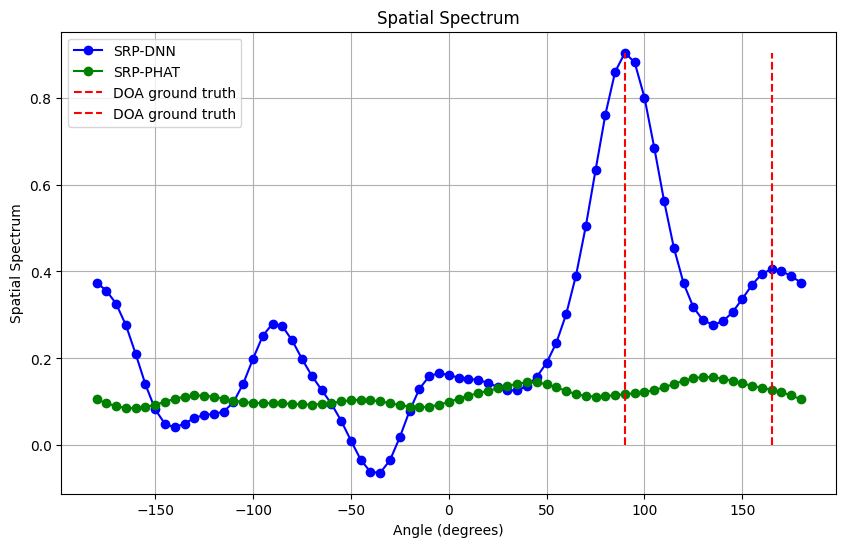

In [57]:
index = torch.randint(1, 5, (1,))
# index = 3

# print(gt[index]['vad_sources'])

ele_index = 18 # 约等于92度的俯仰角
# spatial_spectrum = pred[index]['spatial_spectrum'][0,0,ele_index,:].cpu()
spatial_spectrum = pred[index]['spatial_spectrum'][0,:,ele_index,:].mean(dim=0).cpu()
# spatial_spectrum_24 = pred[index]['spatial_spectrum'][0,24,ele_index,:].cpu()
spatial_spectrum_woDNN = pred_woDNN[index]['spatial_spectrum'][0,0,ele_index,:].cpu()

spatial_max = torch.max(spatial_spectrum.max(),spatial_spectrum_woDNN.max())

doa_gt = (gt[index]['doa'][0,0,1,:] / np.pi * 180).cpu()
doa_DNN = (pred[index]['doa'][0,:,1,:].mean(dim=0) / np.pi * 180).cpu()
doa_woDNN = (pred_woDNN[index]['doa'][0,:,1,:].mean(dim=0) / np.pi * 180).cpu()

angles = torch.arange(-180, 181, 5)

import matplotlib.pyplot as plt
# Plotting the curve
plt.figure(figsize=(10, 6))
plt.plot(angles, spatial_spectrum, marker='o', linestyle='-', color='blue',label='SRP-DNN',)
plt.plot(angles, spatial_spectrum_woDNN, marker='o', linestyle='-', color='green',label='SRP-PHAT')

for i in range((doa_gt.shape[0])):
    plt.plot([doa_gt[i],doa_gt[i]],[0,spatial_max],'--',color='red',label='DOA ground truth')

plt.title('Spatial Spectrum')
plt.xlabel('Angle (degrees)')
plt.ylabel('Spatial Spectrum')
plt.legend()
plt.grid(True)

print(doa_gt,doa_DNN,doa_woDNN)

In [28]:
pred[index]['doa'].shape

torch.Size([1, 25, 2, 2])

In [31]:
pred[index]['doa'][0,:,1,:].mean(dim=0)

tensor([0.6877, 1.0786], device='cuda:0')

In [ ]:
angle_90 = gt_angles > 90
gt_angles[angle_90]

NameError: name 'gt_angles' is not defined

In [ ]:
pred_angles[angle_90]

tensor([70.0000, 80.0000, 10.0000, 55.0000, 65.0000, 70.0000, 60.0000, 90.0000,
        75.0000, 45.0000, 75.0000, 55.0000, 35.0000, 65.0000, 40.0000, 70.0000,
        35.0000, 55.0000, 50.0000, 50.0000, 10.0000, 55.0000, 35.0000, 70.0000,
        15.0000, 75.0000, 80.0000, 65.0000, 35.0000, 60.0000, 55.0000, 80.0000,
         0.0000, 65.0000, 75.0000, 60.0000, 20.0000,  0.0000, 90.0000, 55.0000,
        70.0000, 60.0000, 80.0000, 55.0000, 60.0000, 30.0000, 70.0000, 70.0000,
        80.0000, 70.0000, 90.0000, 60.0000, 75.0000, 30.0000, 75.0000, 75.0000,
        70.0000, 70.0000, 75.0000, 45.0000, 60.0000, 75.0000, 65.0000,  5.0000,
        55.0000, 70.0000, 70.0000, 80.0000, 90.0000, 15.0000, 70.0000, 90.0000,
         5.0000, 90.0000, 10.0000, 10.0000, 70.0000, 60.0000, 75.0000, 55.0000,
        40.0000, 90.0000, 70.0000, 55.0000, 45.0000, 15.0000, 50.0000, 75.0000,
        75.0000, 40.0000, 40.0000, 75.0000, 25.0000, 65.0000, 25.0000, 15.0000,
        40.0000, 60.0000, 80.0000, 40.00

In [ ]:
torch.abs(gt_angles[angle_90] - pred_angles[angle_90]).sum() / 1000

tensor(17.3783)